In [3]:
import os
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from matplotlib import pyplot as plt

from torch.utils.data import Dataset
from PIL import Image
import glob

from torchvision import models
import tqdm

import time
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision.transforms import Resize, Compose, ToPILImage, ToTensor
import pickle
import math
import random
from torchvision.transforms import RandomCrop
#os.chdir('/projectnb/cs585bp/jkoh/')
#from SILog import SILogLoss
#os.chdir('/projectnb/cs585bp/krishna/project/')

OUT_SIZE = (2200, 1550)

In [4]:
## a pretty function, but it doesn't work :(
    ##our model doesn't do exactly half upscaling because the dimensions aren't powers of 2. using resize instead

def reduce_tensor(input_tensor, scale_down = 2, mode = "mean"):
    """
    mode can be mean, max, or min
    """
    batch, _, input_w, input_h = input_tensor.shape
    output_w = int(input_w/scale_down)
    output_h = int(input_h/scale_down)

    output_tensor = input_tensor.view(batch,scale_down**2,output_w,output_h)
    
    if mode == "mean":
      output_tensor = output_tensor.mean(dim=1)

    #if mode == "min":
     # output_tensor = torch.min(output_tensor,1)

    #if mode == "max":
     # output_tensor = output_tensor.max(dim=1)
    
    output_tensor = output_tensor.unsqueeze(1)
    
    return output_tensor

In [7]:
i_t = torch.ones((1,1,2200,1550))
r = reduce_tensor(i_t, scale_down = 2)
r.shape
t = transforms.Resize((500,200))(i_t)
t.shape

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([1, 1, 500, 200])

In [ ]:
transforms.Resize(OUT_SIZE)9

In [4]:
c = torch.ones(1,5,10,10)
c.shape
c[:,-1,:,:].unsqueeze(1).shape

torch.Size([1, 1, 10, 10])

In [5]:
class MonocularDepthDataset(Dataset):
    def __init__(self, df, in_transform=None,out_transform = None ):
        self.df = df
        self.in_transform = in_transform
        self.out_transform = out_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.iloc[idx]['image']
        depth_path = self.df.iloc[idx]['depth']

        image = Image.open(image_path)
        depth = Image.open(depth_path)

        #torch.Size([1, 1, 2200, 1550])
        #torch.Size([1, 1, 1098, 773]) #d_0
        #torch.Size([1, 1, 550, 388]) #d_1
        #torch.Size([1, 1, 275, 194]) #d_2
        #torch.Size([1, 1, 138, 97]) #d_3
        #torch.Size([1, 1, 69, 49]) #d_4

        d_0 = depth.Resize((1098, 773))(depth)
        d_1 = depth.Resize((550, 388))(depth)
        d_2 = depth.Resize((275, 194))(depth)
        d_3 = depth.Resize((138, 97))(depth)
        d_4 = depth.Resize((69, 49))(depth)


        if self.in_transform:
            image = self.in_transform(image)
        if self.out_transform:
            depth = self.out_transform(depth)
        #print(depth_path,depth.shape)
        
        return image, depth, d_0, d_1, d_2, d_3, d_4

In [8]:
def conv_relu_block(in_channel,out_channel,kernel,padding):
    return nn.Sequential(
            nn.Conv2d(in_channel,out_channel, kernel_size = kernel, padding=padding),
            nn.ReLU()) #nn.ReLU(inplace=True) #nn.Ge

In [9]:
class vanilla_unet_early_exit(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        self.input_1 = conv_relu_block(3,3,3,1) ##grayscale inputs
        #self.input_2 = conv_relu_block(64, 64, 3, 1) #no extra channels

        self.base_model = models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.l0 = nn.Sequential(*self.base_layers[:3])
        self.U0_conv = conv_relu_block(64, 64, 1, 0)
        self.conv_up0 = conv_relu_block(64 + 256, 128, 3, 0)

        self.l1 = nn.Sequential(*self.base_layers[3:5])
        self.U1_conv = conv_relu_block(64, 64, 1, 0)
        self.conv_up1 = conv_relu_block(64 + 256, 256, 3, 1)

        self.l2 = self.base_layers[5]
        self.U2_conv = conv_relu_block(128, 128, 1, 0)
        self.conv_up2 = conv_relu_block(128 + 512, 256, 3, 1)

        self.l3 = self.base_layers[6]
        self.U3_conv = conv_relu_block(256, 256, 1, 0)
        self.conv_up3 = conv_relu_block(256 + 512, 512, 3, 1)

        self.l4 = self.base_layers[7]
        self.U4_conv = conv_relu_block(512, 512, 1, 0)

        self.conv_up4 = conv_relu_block(64 + 128, 64, 3, 1)

        self.out4 = nn.Conv2d(128, n_class, 1)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        x = torch.cat([x,x,x], axis = 1)
        x = self.input_1(x)
        
        #print(x.shape,'x')
         #concat on channel
        #x_one = self.input_2(x_one)
        block0 = self.l0(x)
        block1 = self.l1(block0)
        block2 = self.l2(block1)
        block3 = self.l3(block2)
        block4 = self.l4(block3)

        block4 = self.U4_conv(block4)
        b4_out = block4[:,-1,:,:].unsqueeze(1)
        #print(b4_out.shape, "block_4")
        x = nn.Upsample(size = (138,97), mode='bilinear', align_corners=True)(block4)
        block3 = self.U3_conv(block3)
        
        x = torch.cat([x, block3], axis=1)
        
        x = self.conv_up3(x)

        b3_out = x[:,-1,:,:].unsqueeze(1)
        #print(b3_out.shape, "block3")
        x = nn.Upsample(size = (275,194), mode='bilinear', align_corners=True)(x)
        
        block2 = self.U2_conv(block2)
        
        #print(x.shape, block2.shape)
        x = torch.cat([x, block2], axis=1)
        
        x = self.conv_up2(x)
        b2_out = x[:,-1,:,:].unsqueeze(1)
        #print(b2_out.shape, "block2")
        x = nn.Upsample(size = (550,388), mode='bilinear', align_corners=True)(x)
        block1 = self.U1_conv(block1)
        #print(x.shape, block1.shape)
        
        x = torch.cat([x, block1], axis=1)
        
        x = self.conv_up1(x)
        b1_out = x[:,-1,:,:].unsqueeze(1)
        #print(b1_out.shape, "block1")
        x = nn.Upsample(size = (1100, 775), mode='bilinear', align_corners=True)(x) 
        block0 = self.U0_conv(block0)

        #print(x.shape, block0.shape)
        x = torch.cat([x, block0], axis=1)

        
        x = self.conv_up0(x)
        b0_out = x[:,-1,:,:].unsqueeze(1)
        #print(b0_out.shape, "block0")
        out4 = self.out4(x)

        out4_upsampled = F.interpolate(out4, size=OUT_SIZE, mode='bilinear', align_corners=True)
        
        out = out4_upsampled
        
        
        return out, b0_out, b1_out, b2_out, b3_out, b4_out

In [10]:
m = vanilla_unet_early_exit(n_class=1)
input = torch.zeros((1,1,2200,1550))

o = m.forward(input)
for i in o:
  print(i.shape)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 185MB/s]


torch.Size([1, 1, 2200, 1550])
torch.Size([1, 1, 1098, 773])
torch.Size([1, 1, 550, 388])
torch.Size([1, 1, 275, 194])
torch.Size([1, 1, 138, 97])
torch.Size([1, 1, 69, 49])


In [ ]:
model = vanilla_unet_early_exit(n_class=1)
model = nn.DataParallel(model)
model = model.to('cuda')

/share/pkg.7/pytorch/1.13.1/install/lib/SCC/../python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/share/pkg.7/pytorch/1.13.1/install/lib/SCC/../python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<ipython-input-6-9aea19feea06>:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(num_epochs)):


  0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-6-9aea19feea06>:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for images, depths in tqdm.tqdm_notebook(train_dataloader):


  0%|          | 0/447 [00:00<?, ?it/s]

-287.26147
Train Loss: 0.08200735480460011


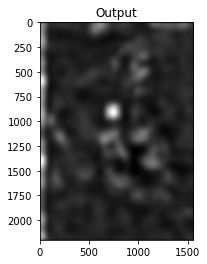

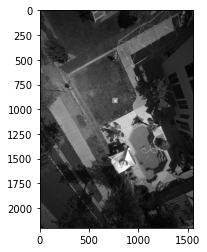

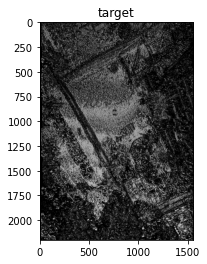

  0%|          | 0/447 [00:00<?, ?it/s]

-416.30814
Train Loss: 0.07331032294288312


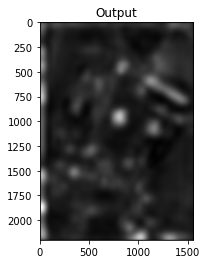

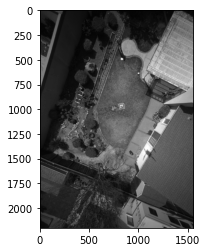

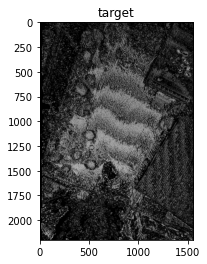

  0%|          | 0/447 [00:00<?, ?it/s]

-355.1269
Train Loss: 0.07930938242799217


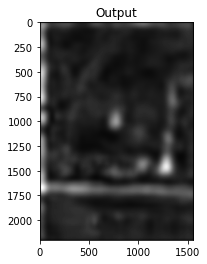

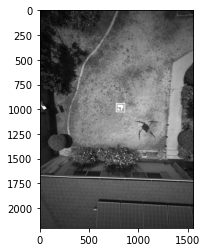

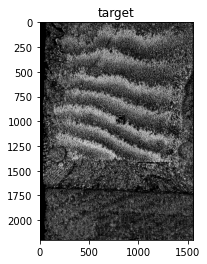

  0%|          | 0/447 [00:00<?, ?it/s]

-343.03384
Train Loss: 0.08371183322846756


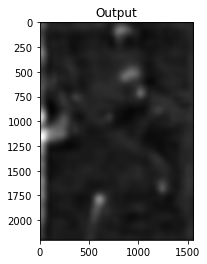

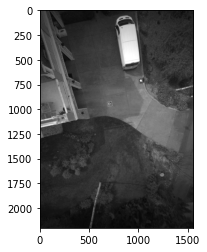

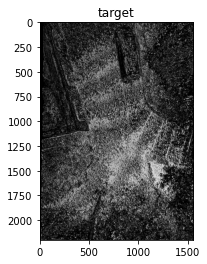

  0%|          | 0/447 [00:00<?, ?it/s]

-329.89108
Train Loss: 0.0785852897353887


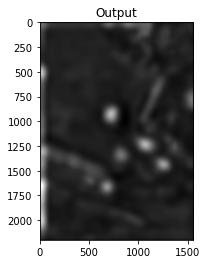

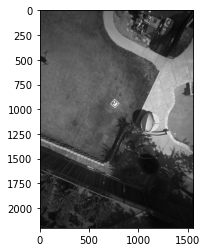

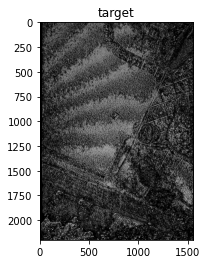

  0%|          | 0/447 [00:00<?, ?it/s]

-313.21686
Train Loss: 0.073850627446868


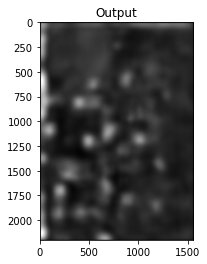

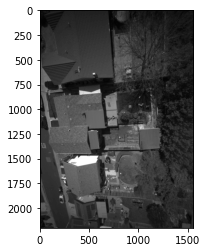

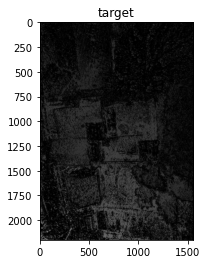

  0%|          | 0/447 [00:00<?, ?it/s]

-299.38962
Train Loss: 0.0766221970253076


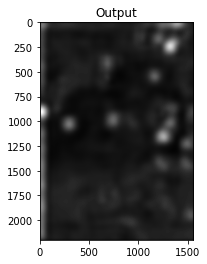

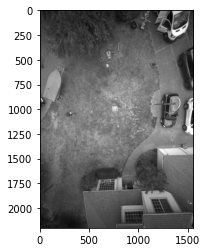

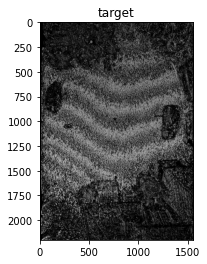

  0%|          | 0/447 [00:00<?, ?it/s]

In [ ]:
# Set hyperparameters, dataset paths, and other configurations
batch_size = 4
learning_rate = 0.001
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

in_transform = transforms.Compose([
    transforms.Resize(OUT_SIZE),
    transforms.ToTensor()
])

out_transform = transforms.Compose([
    transforms.Resize(OUT_SIZE),
    transforms.ToTensor()
])

df = pd.read_csv('train.csv')
train_dataset = MonocularDepthDataset(df, in_transform = in_transform, out_transform = out_transform)
#val_dataset = MonocularDepthDataset(val_image_paths, val_depth_paths, transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16)
#val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


criterion = SILogLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

for epoch in tqdm.tqdm_notebook(range(num_epochs)):
    #train_loss = train(model, train_dataloader, optimizer, criterion, device)
    
    model.train()
    running_loss = 0.0
    n = 0
    for images, depths, d_0, d_1, d_2, d_3, d_4 in tqdm.tqdm_notebook(train_dataloader):
        images = images.to(device)
        depths = depths.to(device)
        d_0 = d_0.to(device)
        d_1 = d_1.to(device)
        d_2 = d_2.to(device)
        d_3 = d_3.to(device)
        d_4 = d_4.to(device)
        
        optimizer.zero_grad()

        out, b0_out, b1_out, b2_out, b3_out, b4_out = model(images)
        #print('out shape',outputs.shape)
        loss_pred = criterion(out, depths) ##output,targets
        loss_0 = criterion(b0_out, d_0)
        loss_1 = criterion(b1_out, d_1)
        loss_2 = criterion(b2_out, d_2)
        loss_3 = criterion(b3_out, d_3)
        loss_4 = criterion(b4_out, d_4)
        loss = loss_pred + loss_0 + loss_1 + loss_2 + loss_3 + loss_4


        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        n += 1
        if n > 50 : break
    dataiter = iter(train_dataloader)
    example = next(dataiter)
    target = example[1]
    example = example[0]
    #print(example.shape)
    ex_in = example.cuda()
    out_vis = model(ex_in).detach().cpu().numpy()[0][0]
    print(np.max(out_vis))
    #print(out_vis.shape)
    train_loss = running_loss / len(train_dataloader)
    #print(out_vis)
    print("Train Loss:",train_loss)
    out_vis = np.nan_to_num(np.rint((out_vis/np.max(out_vis))*255))
    
    #print(out_vis)
    plt.imshow(out_vis, interpolation='nearest', cmap='gray')
    plt.title("Output")
    plt.show()
    plt.imshow(example[0][0].detach().numpy(), cmap='gray')
    plt.show()
    plt.title("target")
    target = target[0][0].detach().numpy()
    plt.imshow(np.rint((target/np.max(target))*255), cmap='gray')
    plt.show()

    #val_loss = validate(model, val_dataloader, criterion, device)